## Data Analysis - Inferential Statistics
There are time series techniques that can be performed on each to retrieve the following components of the time series. These are important aspects of each time series that I will investigate:
- Level
- Trend
- Seasonality
- Noise

I'll start by assessing the aforementioned qualities on the total demand. This will be a nice introduction to the techniques that I'll be using and how I'll be using them on a more refined scale for each individual station, later. ~~demand per station, which is, how many bikes are leaving a station per day or month. To do by day is to have the foundations for the monthly calculation. Since creating ARIMA models requires ~~

We need a stationary time series before we can perform any type of forecasting. These components are necessary for forecasting:
- LIST OUT THE NECESSARY REQUIREMENTS from AILEEN NIELSEN'S TALK

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
# For time series analysis
from statsmodels.tsa import stattools

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Wrangling in one Step
# Specify columns to use
columns = ['bikeid', 'birth year', 'end station id', 
           'end station latitude', 'end station longitude', 'end station name',
           'gender', 'start station id', 'start station latitude', 'start station longitude',
           'start station name', 'starttime', 'stoptime', 'tripduration', 'usertype']

# use your path
path = r'/Users/vincent_zaballa/Springboard_Assignments/capstone_proj_2/CITI_BIKE/2016_data' 
all_files = glob.glob(os.path.join(path, "*.csv"))

# Appending all imported dataframes to empty df
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_, index_col=None, header=0)
    list_.append(df)
bike_df = pd.concat(list_)

# Naming columns for future use
bike_df.columns = columns + bike_df.columns[15:].tolist()

# Creating left and right dfs
right_df = bike_df[bike_df.iloc[:,0].notnull() == False]
left_df = bike_df[bike_df.iloc[:,0].notnull() == True]
right_df = right_df.dropna(axis=1, how='all')
left_df = left_df.dropna(axis=1, how='all')

# Convert individual dfs' timestamps
# Need to convert two different format dfs to timestamp beforehand to speed things up MASSIVELY
right_df.starttime = pd.to_datetime(right_df.starttime, format='%m/%d/%Y %H:%M:%S')
right_df.stoptime = pd.to_datetime(right_df.stoptime, format='%m/%d/%Y %H:%M:%S')
left_df.starttime = pd.to_datetime(left_df.starttime, format='%Y-%m-%d %H:%M:%S')
left_df.stoptime = pd.to_datetime(left_df.stoptime, format='%Y-%m-%d %H:%M:%S')

# Combining
frames = [right_df, left_df]
bike_df = pd.concat(frames, axis=0)

In [4]:
# Setting starttime as the index
bike_df.index = bike_df['starttime']
bike_df = bike_df.sort_index()

# Fixing Null Values
# Setting NaN values equal to average age
bike_df[bike_df['birth year'].notnull() == False] = np.ceil(bike_df['birth year'].mean()).astype(int)

# Converting the whole column to int to save space
bike_df.loc[:,'birth year'] = bike_df['birth year'].copy().astype(int)
bike_df.loc[:,'tripduration'] = bike_df['tripduration'].copy().astype(int)
bike_df.loc[:,'end station id'] = bike_df['end station id'].copy().astype(int)
bike_df.loc[:,'start station id'] = bike_df['start station id'].copy().astype(int)
bike_df.loc[:,'gender'] = bike_df['gender'].copy().astype(int)
bike_df.loc[:,'bikeid'] = bike_df['bikeid'].copy().astype(int)

# Create a one-time user gender class (unknown) instead of "Other" class
bike_df.loc[:,'gender'].loc[bike_df['usertype'] == 'Customer'] = 3

# Fixing a station's lat/lon
bike_df.loc[:, 'end station latitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = 40.75903008
bike_df.loc[:, 'end station longitude'][bike_df['end station name'] == 'NYCBS Depot BAL - DYR'] = -73.9938587

# Deleting anomalous (no data) station
bike_df = bike_df[bike_df['end station name'] != 'SSP - Basement']

# Removing the missing start station lat/lons
bike_df = bike_df[bike_df['start station longitude'] != 0]

# Creating distance travelled
# Distance travelled - vectorized
bike_df['LAT_start_rad'], bike_df['LON_start_rad'] = np.radians(bike_df['start station latitude']), np.radians(bike_df['start station longitude'])
bike_df['LAT_end_rad'], bike_df['LON_end_rad'] = np.radians(bike_df['end station latitude']), np.radians(bike_df['end station longitude'])
bike_df['dLON'] = bike_df['LON_end_rad'] - bike_df['LON_start_rad']
bike_df['dLAT'] = bike_df['LAT_end_rad'] - bike_df['LAT_start_rad']
bike_df['distance_miles'] = 3961 * 2 * np.arcsin(np.sqrt(
    np.sin(bike_df['dLAT']/2)**2 + np.cos(bike_df['LAT_start_rad']) * np.cos(bike_df['LAT_end_rad']) * np.sin(bike_df['dLON']/2)**2
))
del bike_df['LON_start_rad'], bike_df['LAT_start_rad'], bike_df['LAT_end_rad'], bike_df['LON_end_rad'], bike_df['dLON'], bike_df['dLAT']


# Average velocity - Assuming they went in a straight line and were moving the entire time...
bike_df['speed_miles/hour'] = bike_df['distance_miles'] / (bike_df['tripduration']/3600)

# deleting max speed data error (trip duration way too long)
bike_df = bike_df.loc[bike_df['speed_miles/hour'] != bike_df['speed_miles/hour'].max()]

/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# Age to use as possible feature
bike_df['age'] = 2017 - bike_df.loc[:,'birth year']

# Simplify by making a univariate, total bike counts, dataframe
total_DayCounts_df = bike_df.resample('D').apply({'bikeid':'count'})
print('Number of Days (leap year!): ',len(total_DayCounts_df))
total_DayCounts_df.columns = ['ride_count']

Number of Days (leap year!):  366


Just as a review, here is the daily number of trips.

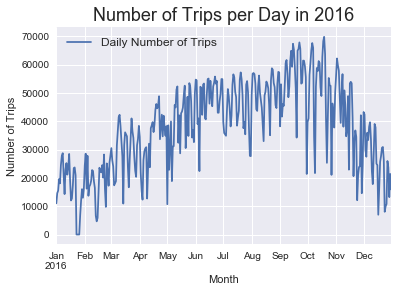

In [7]:
total_DayCounts_df.rename(columns={'ride_count': 'Daily Number of Trips'}).plot()
plt.legend(loc='best', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day in 2016', fontsize=18)

## Autocorrelation Function (ACF)
Now, I'll plot the autocorrelation of this time series data to better understand if there are any signals that are statistically significant.

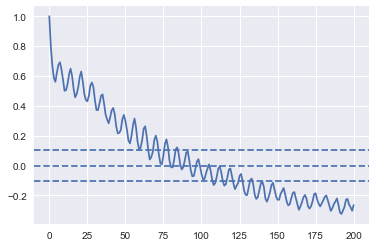

In [28]:
from statsmodels.tsa.stattools import acf
acf_result = acf(total_DayCounts_df, nlags=200)

plt.plot(acf_result)
plt.axhline(y=0, linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(total_DayCounts_df)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(total_DayCounts_df)),linestyle='--')

According to this ACF, it looks like everything is relevant, as is signified by the significance lines at y=1.96. However, we know this not to be the case...
Remember, at x=0 means that each data point correlates with itself, equally.

Autocorrelation is really looking for internal structure. There is an obvious trend in the original data, plotted before the ACF figure, that needs to be taken into account.

Now, I want to de-trend the data. This can be done in a variety of manners, such as applying a log transformation, local smoothing (the red smoothed line from the rolling window), or even a linear regression of the general trend. Each has its strengths and weaknesses, and place of use.

The goal of this is getting to **stationarity**. We want the variance and the mean to be fairly stable. Remember the individual stations? They all had very different variances and means.

The ACF is a good diagnostic to determine what kind of model we want to use to predict future events. 

## Pre-prediction Munging and Stationarity
Next is munging in order to get the data into a format suitable for an ARIMA model.

To use an ARIMA model, one of the most inclusive, general, and powerful ways of predicting future events, you need stationarity.

Stationarity:
- Constant mean
- Constant variance
- Constant autocorrelation

First method to try and create a stationary time series: Differencing. This can handle both the trend and seasonality of some datasets.

Other methods: Moving Average and Linear Regression. Calculating the moving average and subtracting that from the original dataset can be computationally taxing, but it is a very accurate measure. Linear regression is direct in its application, but is worse overall because there is still a sinusoidal trend in the data.

### Seasonality
There is additive and multiplicative seasonality. The simplest way to remove seasonality is to find the average de-trended values for a season... (how do you distinguish seasons?). However, the more common use is a loess, which is locally weighted scatterplot smoothing. 

To use loess method:
- Window of specified width is placed over the data
- A weighted regression line or curve is fitted to the data, with points closest to the center of the curve having greatest weight
- Weighting is reduced on points farthest from regression line/curve and calculation is rerun several times
    - This yields one point on loess curve
    - Helps reduce impact of outliers
    - Computationally taxing
    
## Testing Stationarity
Once I think I have a stationary dataset, I need to test that assumption with the Dickey-Fuller Test. This tests the null hypothesis of whether a unit root is present in an autoregressive model. Basically testing whether p=1.

$y_t = py_{t-1} + u_t$

The test gives back **several different values** to help assess significance with standard p-value reasoning. The basic intuition is that *p* having a unit value means it is not stationary.

# Forecasting
Thinking about Autoregressive Integrative Moving Average (ARIMA) models. Here are some of the components:

**Moving Average (MA)**

Takes the form:

$X_t = \mu + \epsilon_t + \theta_{1}\epsilon_{t-1} + \cdots + \theta_{q}\epsilon_{t-q}$

Where $\mu$ is the mean of the series, $\theta$ are parameters, and $\theta_q$ is not zero.

This is a stationary process regadless the parameter ($\theta$) values.

**Autoregressive Process (AR)**

Takes the form:

$X_t = \phi_1X_{t-1} + \cdots + \phi_pX_{t-p} + \epsilon_t$

This is a stationary process if $abs(\phi) < 1$

This is saying your value at a particular time depends on your past values. It's kind of like regressing on yourself.

**Differencing (I)**

This is the differencing from trying to detrend the data. The 'I' is optional, as there are also ARMA models that exclude it, but it can be seen as record-keeping.

## Stationarity
Remember, the time series must be stationary in order for an ARIMA model to work. If it cannot be made stationary, then an ARIMA model cannot be used. ARIMA models can be seen as a combination of signal and noise, where we want to extract the signal to produce future predictions.

## Applying the Appropriate ARIMA Model
To determine what ARIMA model to use, I'll plot the data, the ACF, and PACF. I'll use the plots to determine how to detrend the data. After that, most software will use a maximum likelihood estimation to determine the appropriate ARIMA parameters. This can include an AIC and BIC. 
- Use PACF for AR model diagnostics
- Use ACF for MA model diagnostics

If it's an AR(1) process, you can only get the next set of observations, so watch out for this. However, the higher the order, the more likely you're overfitting your data.

If a basic ARIMA model does not work very well for the data, then it is possible to go to a seasonal ARIMA model, where the seasonality is measured and labeled, and the autoregressive term is improved. Info in Aileen Nielsen's video.

## Dynamic Time Warping (DTW)
Can be used to measure how similar some of the demands are for each station...